In [1]:
# useful to reload automatically a module if its code has been modified 
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys 
sys.path.append('..')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data.dataloader import DataLoader
from torch.optim import Adam, lr_scheduler
from torch.nn import BCELoss
from tqdm import tqdm

from sources.lgg_dataset import LGGDataset
from sources.unet import UNet

# Deep-Learning brain MRI segmentation

### Split datasets

Number of images in training set :  2750
Number of images in validation set :  589
Number of images in test set :  590


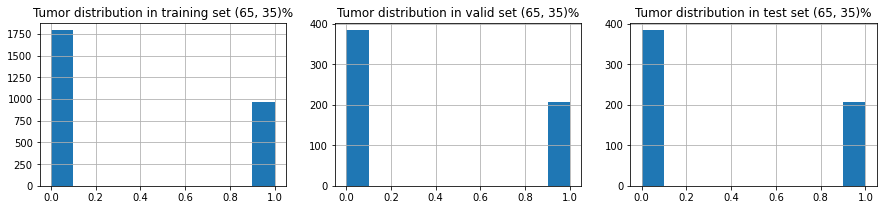

In [36]:
# read dataframe
df = pd.read_csv("image_data.csv")

# prepare train/valid/test (70%-15%-15%) sets
train_df, temp_df = train_test_split(df, train_size=0.7, stratify=df.has_tumor, random_state=0)
valid_df, test_df = train_test_split(temp_df, train_size=0.5, stratify=temp_df.has_tumor, random_state=0)

train_df = train_df.reset_index()
valid_df = valid_df.reset_index()
test_df = test_df.reset_index()

print('Number of images in training set : ', len(train_df))
print('Number of images in validation set : ', len(valid_df))
print('Number of images in test set : ', len(test_df))

# display distributions
def distribution(df):
    return (round(100*len(df[df.has_tumor==0])/len(df)), 
            round(100*len(df[df.has_tumor==1])/len(df))) 

fig = plt.figure(figsize=(15, 3))
plt.subplot(131), 
hist=train_df.has_tumor.hist(), 
plt.title('Tumor distribution in training set {0}%'.format(distribution(train_df)))
plt.subplot(132), valid_df.has_tumor.hist(), 
plt.title('Tumor distribution in valid set {0}%'.format(distribution(valid_df)))
plt.subplot(133), test_df.has_tumor.hist(), 
plt.title('Tumor distribution in test set {0}%'.format(distribution(test_df)))
plt.show()


### Dataloaders

In [4]:
# hyper-parameters
learning_rate = 1e-4
epochs = 25
batch_size = 2

#random state for repeatable experiments
#np.random.seed(0)
torch.manual_seed(0)

In [37]:
# create datasets & dataloaders
train_dataset = LGGDataset(train_df)
valid_dataset = LGGDataset(valid_df)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [7]:
# create PyTorch model 
# see https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/
model = UNet(in_channels=1, out_channels=1, init_features=32)

# weights initialization function
def init_weights(m):
  if type(m) == torch.nn.Conv2d:
    torch.nn.init.xavier_uniform_(m.weight)
  if type(m) == torch.nn.BatchNorm2d:
    torch.nn.init.uniform_(m.weight)
    torch.nn.init.constant_(m.bias, 0)

model.apply(init_weights)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [8]:
# optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer)

# loss
loss_function = BCELoss() 

In [40]:
# training loop
historic = {'loss': []}
avg_loss = 0

pbar = tqdm(range(epochs))
for epoch in pbar:  # loop over the dataset multiple times
    pbar.set_description('Epoch {0}'.format(epoch))
    
    ############ TRAINING ###########
    model.train()
    
    for i, data in enumerate(train_dataloader):
        # get the inputs
        image, mask = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        prediction = model(image)
        loss = loss_function(prediction, mask)
        loss.backward()
        optimizer.step()

        # print 
        avg_loss += loss.item()
        pbar.set_postfix({'avg_loss': avg_loss/(i+1)})
    
    historic['loss'].append(avg_loss/len(train_dataloader))
    avg_loss = 0
    
    ############ VALIDATION ###########
    #model.eval()
    
print('Finished Training')

Epoch 0:   0%|          | 0/25 [00:36<?, ?it/s, avg_loss=0.532]


KeyboardInterrupt: 